In [110]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import layers
from keras.models import Model
from keras.layers import Input, Dense, Lambda
from keras.layers import Concatenate
from collections import deque
import random
from quanser.hardware import HIL 
from pal.products.qube import QubeServo3
from pal.utilities.math import SignalGenerator, ddt_filter
from threading import Thread
import time
import signal

In [111]:
# # board.close()
# # Open connection to QUBE
# # board = HIL("qube_servo3_usb", "0")

# encoder_channels = np.array([0, 1], dtype=np.uint32)
# motor_channels = np.array([0], dtype=np.uint32)
# counts = np.zeros(2, dtype=np.int32)

# ENCODER_RES = 2048
# ARM_RAD_PER_COUNT = 2*np.pi / ENCODER_RES
# PEND_RAD_PER_COUNT = 2*np.pi / ENCODER_RES

# dt = 0.01  # 10 ms
# theta_arm_prev  = counts[0] * ARM_RAD_PER_COUNT
# theta_pend_prev = counts[1] * PEND_RAD_PER_COUNT

In [112]:
class ReplayBuffer:
    def __init__(self, capacity=100000):
        self.buffer = deque(maxlen=capacity)
    def store(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = map(np.array, zip(*batch))
        return (np.array(states, dtype=np.float32),
            np.array(actions, dtype=np.float32),
            np.array(rewards, dtype=np.float32),
            np.array(next_states, dtype=np.float32),
            np.array(dones, dtype=np.float32))
    def size(self):
        return len(self.buffer)
    
def soft_update(target_weights, online_weights, tau=0.005):
    for (target, online) in zip(target_weights, online_weights):
        target.assign(target * (1 - tau) + online * tau) 

replay_buffer = ReplayBuffer()

In [113]:
state_size = 4
action_size = 1
gamma = 0.99 # discount rate
learning_rate = 0.001 # learning rate

# Define the actor model
states_inputs = Input(shape=(state_size,))
dense = Dense(128, activation='tanh')(states_inputs)
dense = Dense(128, activation='tanh')(dense)
outputs = Dense(action_size, activation='tanh')(dense)
outputs = keras.layers.Lambda(lambda x: x * 2.0)(outputs)  
actor_model = Model(inputs=states_inputs, outputs=outputs)

# Critic 1
state_input1 = Input(shape=(state_size,))
action_input1 = Input(shape=(action_size,))
concat1 = Concatenate()([state_input1, action_input1])
dense1 = Dense(128, activation='tanh')(concat1)
dense1 = Dense(128, activation='tanh')(dense1)
sigmoid_layer = Dense(1, activation='tanh')(dense1)
output1 = Dense(1)(sigmoid_layer)
critic_model1 = Model([state_input1, action_input1], output1)

# Critic 2
state_input2 = Input(shape=(state_size,))
action_input2 = Input(shape=(action_size,))
concat2 = Concatenate()([state_input2, action_input2])
dense2 = Dense(128, activation='tanh')(concat2)
dense2 = Dense(128, activation='tanh')(dense2)
sigmoid_layer2 = Dense(1, activation='tanh')(dense2)
output2 = Dense(1)(sigmoid_layer2)
critic_model2 = Model([state_input2, action_input2], output2)

try:
    actor_model.load_weights('saves/quanser/actor_model.weights.h5')
    critic_model1.load_weights('saves/quanser/critic_model1.weights.h5')
    critic_model2.load_weights('saves/quanser/critic_model2.weights.h5')
except:
    pass

actor_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
critic_optimizer1 = tf.keras.optimizers.Adam(learning_rate=learning_rate)
critic_optimizer2 = tf.keras.optimizers.Adam(learning_rate=learning_rate)

target_actor = keras.models.clone_model(actor_model)
target_actor.set_weights(actor_model.get_weights())

target_critic1 = keras.models.clone_model(critic_model1)
target_critic1.set_weights(critic_model1.get_weights())
target_critic2 = keras.models.clone_model(critic_model2)
target_critic2.set_weights(critic_model2.get_weights())

ckpt = tf.train.Checkpoint(actor_optimizer=actor_optimizer,
                           critic_optimizer1=critic_optimizer1, 
                           critic_optimizer2=critic_optimizer2)

# Restore the latest checkpoint with optimizer states
ckpt.restore(tf.train.latest_checkpoint("saves/quanser/optimizers_ckpt")).expect_partial()



In [114]:
# frequency = 500  # Hz
# state_theta_dot = np.array([0,0], dtype=np.float64)
# state_alpha_dot = np.array([0,0], dtype=np.float64)
# with QubeServo3(hardware = 1, pendulum = 1, frequency=frequency) as board:
#     while True:
#         # Have to initialize the board first before reading motorPosition or it won't read
#         board.read_outputs()
#         theta = board.motorPosition 
#         alpha = -board.pendulumPosition 
#         theta_dot, state_theta_dot = ddt_filter(theta, state_theta_dot, 50, 1/frequency)
#         # u - input
#         # state - previous state returned by this function -- initialize to np.array([0,0], dtype=np.float64)
#         # Ts - sample time in seconds
#         # A - filter bandwidth in rad/s
#         alpha_dot, state_alpha_dot = ddt_filter(alpha, state_alpha_dot, 100, 1/frequency)
#         alpha = np.mod(alpha, 2*np.pi) - np.pi
#         alpha = np.cos(alpha)
#         theta = np.clip(theta, (-5*np.pi)/8, (5*np.pi)/8)
#         reward = -(alpha**2 + 0.0001*alpha_dot**2 )
#         print(f"Theta: {theta:.3f}, Theta dot: {theta_dot:.3f}, Alpha: {alpha:.3f}, Alpha dot: {alpha_dot:.3f}", 
#               f"Reward: {reward:.3f}")
#         time.sleep(0.5)

C:\Users\ntk00\AppData\Local\Temp\ipykernel_8852\1979494499.py:67: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  reward = float(reward)


Epoch 200, Total Reward: -1.0743, Q1: -1.6181, Q2: -1.3533, TargetQ: -2.7406 alpha: -3.0618 alpha_dot: -34.8583 voltage: -2.00 theta: 2.7029 theta_dot: 6.0560
Epoch 400, Total Reward: -1.0754, Q1: -1.6426, Q2: -1.5226, TargetQ: -2.6745 alpha: -3.0342 alpha_dot: -32.9836 voltage: 2.00 theta: 2.7243 theta_dot: 10.6296
Epoch 600, Total Reward: -1.2717, Q1: -1.7707, Q2: -1.4180, TargetQ: -2.7294 alpha: 2.7642 alpha_dot: 453.5849 voltage: 2.00 theta: -2.0095 theta_dot: -160.0275
Epoch 800, Total Reward: -1.0442, Q1: -1.5704, Q2: -1.5331, TargetQ: -2.7440 alpha: -2.6538 alpha_dot: -56.7875 voltage: 0.37 theta: -2.0034 theta_dot: -28.8197
Epoch 1000, Total Reward: -1.0405, Q1: -1.7791, Q2: -1.5495, TargetQ: -2.7767 alpha: -2.0647 alpha_dot: 19.1275 voltage: 2.00 theta: -2.0034 theta_dot: -0.0000
Epoch 1200, Total Reward: -1.0402, Q1: -1.7397, Q2: -1.4237, TargetQ: -2.7472 alpha: -2.1660 alpha_dot: 7.7511 voltage: 2.00 theta: -2.0034 theta_dot: -0.0000
Epoch 1400, Total Reward: -1.0401, Q1: -1

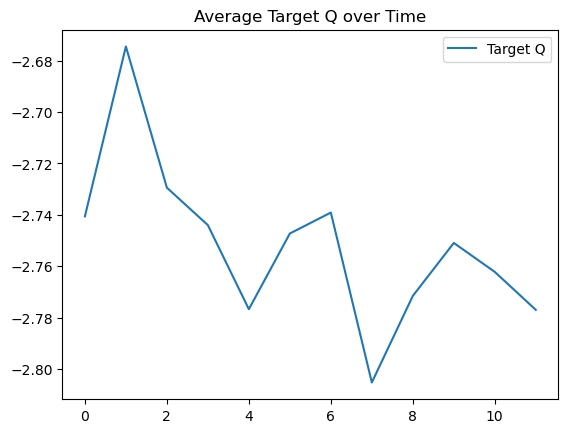

In [115]:
batch_size = 64
history = []
policy_delay = 2  # Delayed policy updates
step = 0
total_reward = 0.0
frequency = 500  # Hz
state_theta_dot = np.array([0,0], dtype=np.float64)
state_alpha_dot = np.array([0,0], dtype=np.float64)
timestamps = 0 

w_theta = 10.0
w_alpha = 0.1
w_theta_dot = 0.001
w_alpha_dot = 0.001
w_u = 0.001
w_du = 0.3
prev_action = np.zeros(action_size, dtype=np.float32)
avg_q = []
episode_length = 200   # number of control steps per episode
step_in_episode = 0
try: 
    with QubeServo3(hardware = 1, pendulum = 1, frequency=10) as board:
        while True:
            for _ in range(200):
                avg_q1, avg_q2, avg_target_q = 0.0, 0.0, 0.0
                step += 1 
                board.read_outputs()
                theta = board.motorPosition * -1
                alpha = board.pendulumPosition 
                alpha = np.mod(alpha, 2*np.pi) - np.pi

                theta_dot, state_theta_dot = ddt_filter(theta, state_theta_dot, 50, 1/frequency)
                alpha_dot, state_alpha_dot = ddt_filter(alpha, state_alpha_dot, 100, 1/frequency)

                state = np.array([theta, theta_dot, alpha, alpha_dot], dtype=np.float32)

                action = actor_model(tf.convert_to_tensor([state], dtype=tf.float32)).numpy()[0]
                # action = action + np.random.normal(0, 0.2, size=action_size)  # Add exploration noise
                # action = np.clip(action, -2, 2) 
                board.write_voltage(action)

                board.read_outputs()
                next_theta = board.motorPosition * -1
                next_alpha = board.pendulumPosition
                next_alpha = np.mod(next_alpha, 2*np.pi) - np.pi
                next_theta_dot, state_theta_dot = ddt_filter(next_theta, state_theta_dot, 50, 1/frequency)
                next_alpha_dot, state_alpha_dot = ddt_filter(next_alpha, state_alpha_dot, 100, 1/frequency)
                next_state = np.array([next_theta, next_theta_dot, next_alpha, next_alpha_dot], dtype=np.float32)


                # wrapped_alpha = ((alpha - np.pi + np.pi) % (2*np.pi)) - np.pi
                # reward = -(alpha**2 + 0.0001*alpha_dot**2 + 0.001*action**2)
                if abs(theta) <= (5*np.pi/8) and abs(theta_dot) <= 60:
                    Fk = 0
                else:
                    Fk = -1

                delta_u = action - prev_action
                reward = Fk - ((
                    w_theta * (theta**2) +
                    w_theta_dot * (theta_dot**2) +
                    w_alpha_dot * (alpha_dot**2) +
                    w_u * (action**2) +
                    w_du * (delta_u**2)
                )/1000)
                prev_action = action.copy()
                reward = float(reward)
                total_reward += reward

                replay_buffer.store(state, action, reward, next_state, False)
                state = next_state

            if replay_buffer.size() >= batch_size:
                states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
                states = tf.convert_to_tensor(states, dtype=tf.float32)
                actions = tf.convert_to_tensor(actions, dtype=tf.float32)
                rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
                next_states = tf.convert_to_tensor(next_states, dtype=tf.float32)
                dones = tf.convert_to_tensor(dones, dtype=tf.float32) 

                # add clipped noise to target action
                noise = tf.random.normal(shape=tf.shape(actions), mean=0.0, stddev=0.2, dtype=tf.float32)
                next_actions = target_actor(next_states) + noise
                next_actions = tf.clip_by_value(next_actions, -2.0, 2.0)

                # Compute target Q-values with both critics
                target1 = tf.squeeze(target_critic1([next_states, next_actions]), axis=1)
                target2 = tf.squeeze(target_critic2([next_states, next_actions]), axis=1)
                target_q = rewards + gamma * (1 - dones) * tf.minimum(target1, target2)
                target_q = tf.expand_dims(target_q, axis=1)  # shape (batch,1)
                
                with tf.GradientTape() as tape_critic1, tf.GradientTape() as tape_critic2:
                    q1 = critic_model1([states, actions], training=True)
                    q2 = critic_model2([states, actions], training=True)

                    # Compute losses
                    loss1 = tf.keras.losses.MSE(target_q, q1)
                    loss2 = tf.keras.losses.MSE(target_q, q2)

                avg_q1 = tf.reduce_mean(q1).numpy().item()
                avg_q2 = tf.reduce_mean(q2).numpy().item()
                avg_target_q = tf.reduce_mean(target_q).numpy().item()

                # Get gradients for each critic once
                critic_grad1 = tape_critic1.gradient(loss1, critic_model1.trainable_variables)
                critic_grad2 = tape_critic2.gradient(loss2, critic_model2.trainable_variables)

                # Apply gradients
                critic_optimizer1.apply_gradients(zip(critic_grad1, critic_model1.trainable_variables))
                critic_optimizer2.apply_gradients(zip(critic_grad2, critic_model2.trainable_variables))
                if step % policy_delay == 0:  # Delayed policy updates
                    with tf.GradientTape() as tape_actor: 
                        action = actor_model(states)
                        actor_loss = -tf.reduce_mean(critic_model1([states, action]))

                    actor_grad = tape_actor.gradient(actor_loss, actor_model.trainable_variables)
                    actor_optimizer.apply_gradients(zip(actor_grad, actor_model.trainable_variables))

                    soft_update(target_actor.variables, actor_model.variables, tau=0.005)
                    soft_update(target_critic1.variables, critic_model1.variables, tau=0.005)
                    soft_update(target_critic2.variables, critic_model2.variables, tau=0.005)

            history.append(total_reward)
            if step % 1 == 0:
                avg_q.append(avg_target_q)
                print(f"Epoch {step}, Total Reward: {float(reward):.4f}, "
                f"Q1: {avg_q1:.4f}, Q2: {avg_q2:.4f}, TargetQ: {avg_target_q:.4f}", 
                f"alpha: {alpha:.4f}", f"alpha_dot: {alpha_dot:.4f}", 
                f"voltage: {np.array(action).reshape(-1)[0]:.2f}", 
                f"theta: {theta:.4f}", f"theta_dot: {theta_dot:.4f}")
except KeyboardInterrupt:
    print("\nStopping (Ctrl+C). Saving…")
finally:
    # save weights (use .save_weights if you prefer checkpoint style)
    actor_model.save_weights("saves/quanser/actor_model.weights.h5")
    critic_model1.save_weights("saves/quanser/critic_model1.weights.h5")
    critic_model2.save_weights("saves/quanser/critic_model2.weights.h5")
    ckpt = tf.train.Checkpoint(actor_optimizer=actor_optimizer,
                           critic_optimizer1=critic_optimizer1,
                           critic_optimizer2=critic_optimizer2)
    ckpt.save("saves/quanser/optimizers_ckpt/ckpt")
    plt.title("Average Target Q over Time")
    plt.plot(avg_q, label='Target Q')
    plt.legend()
    print("Done.")

In [ ]:
# batch_size = 32
# history = []
# policy_delay = 2  # Delayed policy updates
# step = 0
# total_reward = 0.0

# try:
#     total_reward = 0.0
#     while True:
#         step += 1
    
#         # 1) read state
#         board.read_encoder(encoder_channels, len(encoder_channels), counts)
#         theta_arm  = counts[0] * ARM_RAD_PER_COUNT
#         theta_pend = counts[1] * PEND_RAD_PER_COUNT
#         theta_arm_dot  = (theta_arm  - theta_arm_prev)  / dt
#         theta_pend_dot = (theta_pend - theta_pend_prev) / dt
#         state = np.array([theta_arm, theta_pend, theta_arm_dot, theta_pend_dot], dtype=np.float32)

#         # 2) select action
#         action_vec = actor_model(tf.convert_to_tensor([state], dtype=tf.float32)).numpy()[0]
#         action_val = float(np.clip(action_vec[0], -2.0, 2.0))  # scalar in [-2,2]; tune to your safe V range

#         # 3) apply action (analog write wants numpy float64 buffer)
#         voltages = np.array([action_val], dtype=np.float64)
#         board.write_analog(motor_channels, len(motor_channels), voltages)

#         # 4) get next_state after action
#         time.sleep(dt)  # maintain loop timing around the actuation
#         board.read_encoder(encoder_channels, len(encoder_channels), counts)
#         next_theta_arm  = counts[0] * ARM_RAD_PER_COUNT
#         next_theta_pend = counts[1] * PEND_RAD_PER_COUNT
#         next_theta_arm_dot  = (next_theta_arm  - theta_arm)  / dt
#         next_theta_pend_dot = (next_theta_pend - theta_pend) / dt
#         next_state = np.array([next_theta_arm, next_theta_pend, next_theta_arm_dot, next_theta_pend_dot], dtype=np.float32)

#         # 5) reward (example: upright pendulum, gentle motion)
#         reward = - ( (np.angle(np.exp(1j*(next_theta_pend - np.pi))))**2
#                      + 0.1*next_theta_pend_dot**2 + 0.01*action_val**2 )
#         total_reward += reward

#         # 6) store
#         replay_buffer.store(state, action_val, reward, next_state, False)

#         # 7) train if enough samples
#         if replay_buffer.size() >= batch_size:
#             states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
#             states      = tf.convert_to_tensor(states, dtype=tf.float32)
#             actions     = tf.convert_to_tensor(actions.reshape(-1,1), dtype=tf.float32)
#             rewards     = tf.convert_to_tensor(rewards, dtype=tf.float32)
#             next_states = tf.convert_to_tensor(next_states, dtype=tf.float32)
#             dones       = tf.convert_to_tensor(dones, dtype=tf.float32)

#             # target policy smoothing
#             noise = np.clip(np.random.normal(0, 0.2, size=(actions.shape[0], 1)), -0.5, 0.5)
#             target_act = tf.clip_by_value(target_actor(next_states) + noise, -2.0, 2.0)

#             # twin critics target
#             t1 = tf.squeeze(target_critic1([next_states, target_act]), axis=1)
#             t2 = tf.squeeze(target_critic2([next_states, target_act]), axis=1)
#             target_q = rewards + gamma * (1.0 - dones) * tf.minimum(t1, t2)

#             # critic updates
#             with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
#                 q1 = tf.squeeze(critic_model1([states, actions]), axis=1)
#                 q2 = tf.squeeze(critic_model2([states, actions]), axis=1)
#                 loss1 = tf.keras.losses.MSE(target_q, q1)
#                 loss2 = tf.keras.losses.MSE(target_q, q2)
#             critic_optimizer1.apply_gradients(zip(tape1.gradient(loss1, critic_model1.trainable_variables),
#                                                   critic_model1.trainable_variables))
#             critic_optimizer2.apply_gradients(zip(tape2.gradient(loss2, critic_model2.trainable_variables),
#                                                   critic_model2.trainable_variables))

#             # delayed actor + target updates
#             if step % policy_delay == 0:
#                 with tf.GradientTape() as tape_actor:
#                     pi = actor_model(states)
#                     actor_loss = -tf.reduce_mean(critic_model1([states, pi]))
#                 actor_optimizer.apply_gradients(zip(tape_actor.gradient(actor_loss, actor_model.trainable_variables),
#                                                     actor_model.trainable_variables))
#                 soft_update(target_actor.variables,   actor_model.variables,   tau=0.005)
#                 soft_update(target_critic1.variables, critic_model1.variables, tau=0.005)
#                 soft_update(target_critic2.variables, critic_model2.variables, tau=0.005)

#         if step % 100 == 0:
#             print(f"Step {step}  reward_sum: {total_reward:.2f}")

#         # update prev angles for next derivative
#         theta_arm_prev, theta_pend_prev = next_theta_arm, next_theta_pend

# except KeyboardInterrupt:
#     print("\nStopping (Ctrl+C). Saving…")
# finally:
#     # save weights (use .save_weights if you prefer checkpoint style)
#     actor_model.save_weights("saves/quanser/actor_model.weights.h5")
#     critic_model1.save_weights("saves/quanser/critic_model1.weights.h5")
#     critic_model2.save_weights("saves/quanser/critic_model2.weights.h5")
#     # set motor to 0V and close safely
#     board.write_analog(motor_channels, 1, np.array([0.0], dtype=np.float64))
#     board.close()
#     print("Done.")

In [ ]:
# while True:
#     # read state
#     # board.close()
#     board.read_encoder(encoder_channels, len(encoder_channels), counts)
#     theta_arm = counts[0] * ARM_RAD_PER_COUNT
#     theta_pend = counts[1] * PEND_RAD_PER_COUNT

#     # compute action from policy
#     action = actor_model(tf.convert_to_tensor([state], dtype=tf.float32)).numpy()[0]
#     u = float(action)

#     # send to motor
#     board.write_analog(motor_channels, 1, [u])

#     time.sleep(dt)  # ~0.01s


In [ ]:
# import numpy as np
# import time
# import tensorflow as tf
# from collections import deque

# # --- HIL/QUBE setup ---
# board.close()
# board = HIL("qube_servo3_usb", "0")
# encoder_channels = np.array([0, 1], dtype=np.uint32)
# motor_channels = np.array([0], dtype=np.uint32)
# counts = np.zeros(2, dtype=np.int32)

# ENCODER_RES = 2048
# ARM_RAD_PER_COUNT = 2*np.pi / ENCODER_RES
# PEND_RAD_PER_COUNT = 2*np.pi / ENCODER_RES
# dt = 0.01  # 10 ms loop

# # --- Replay Buffer ---
# class ReplayBuffer:
#     def __init__(self, capacity=100000):
#         self.buffer = deque(maxlen=capacity)
#     def store(self, state, action, reward, next_state, done):
#         self.buffer.append((state, action, reward, next_state, done))
#     def sample(self, batch_size):
#         batch = np.array(random.sample(self.buffer, batch_size))
#         states, actions, rewards, next_states, dones = map(np.stack, zip(*batch))
#         return states, actions, rewards, next_states, dones
#     def size(self):
#         return len(self.buffer)

# replay_buffer = ReplayBuffer()

# # --- Soft update ---
# def soft_update(target_weights, online_weights, tau=0.005):
#     for (target, online) in zip(target_weights, online_weights):
#         target.assign(target * (1 - tau) + online * tau)

# # --- TD3 models already defined: actor_model, critic_model1, critic_model2, 
# # target_actor, target_critic1, target_critic2
# # optimizers: actor_optimizer, critic_optimizer1, critic_optimizer2

# state_size = 4
# action_size = 1
# gamma = 0.99
# batch_size = 32
# policy_delay = 2
# step = 0

# theta_arm_prev = 0.0
# theta_pend_prev = 0.0

# try:
#     while True:
#         step += 1

#         # --- 1. Read state ---
#         board.read_encoder(encoder_channels, len(encoder_channels), counts)
#         theta_arm = counts[0] * ARM_RAD_PER_COUNT
#         theta_pend = counts[1] * PEND_RAD_PER_COUNT

#         theta_arm_dot = (theta_arm - theta_arm_prev) / dt
#         theta_pend_dot = (theta_pend - theta_pend_prev) / dt
#         theta_arm_prev, theta_pend_prev = theta_arm, theta_pend

#         state = np.array([theta_arm, theta_pend, theta_arm_dot, theta_pend_dot], dtype=np.float32)

#         # --- 2. Compute action ---
#         action = actor_model(tf.convert_to_tensor([state], dtype=tf.float32)).numpy()[0]
#         u_array = np.array([float(action)], dtype=np.float64)

#         # --- 3. Apply action ---
#         board.write_analog(motor_channels, 1, u_array)

#         # --- 4. Read next state ---
#         board.read_encoder(encoder_channels, len(encoder_channels), counts)
#         next_theta_arm = counts[0] * ARM_RAD_PER_COUNT
#         next_theta_pend = counts[1] * PEND_RAD_PER_COUNT
#         next_theta_arm_dot = (next_theta_arm - theta_arm) / dt
#         next_theta_pend_dot = (next_theta_pend - theta_pend) / dt
#         next_state = np.array([next_theta_arm, next_theta_pend, next_theta_arm_dot, next_theta_pend_dot], dtype=np.float32)

#         # --- 5. Compute reward ---
#         reward = - (next_theta_pend**2 + 0.1 * next_theta_pend_dot**2)

#         # --- 6. Store transition ---
#         replay_buffer.store(state, action, reward, next_state, False)

#         # --- 7. Train TD3 ---
#         if replay_buffer.size() >= batch_size:
#             states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
#             states = tf.convert_to_tensor(states, dtype=tf.float32)
#             actions = tf.convert_to_tensor(actions, dtype=tf.float32)
#             rewards = tf.convert_to_tensor(rewards, dtype=tf.float32)
#             next_states = tf.convert_to_tensor(next_states, dtype=tf.float32)
#             dones = tf.convert_to_tensor(dones, dtype=tf.float32)

#             # Target actions with clipped noise
#             noise = np.clip(np.random.normal(0, 0.2, size=actions.shape), -0.5, 0.5)
#             next_actions = tf.clip_by_value(target_actor(next_states) + noise, -12.0, 12.0)

#             # Target Q-values
#             target1 = tf.squeeze(target_critic1([next_states, next_actions]), axis=1)
#             target2 = tf.squeeze(target_critic2([next_states, next_actions]), axis=1)
#             target_q = rewards + gamma * (1 - dones) * tf.minimum(target1, target2)

#             # Critic updates
#             with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
#                 q1 = critic_model1([states, actions], training=True)
#                 q2 = critic_model2([states, actions], training=True)
#                 loss1 = tf.keras.losses.MSE(target_q, q1)
#                 loss2 = tf.keras.losses.MSE(target_q, q2)

#             critic_grad1 = tape1.gradient(loss1, critic_model1.trainable_variables)
#             critic_grad2 = tape2.gradient(loss2, critic_model2.trainable_variables)
#             critic_optimizer1.apply_gradients(zip(critic_grad1, critic_model1.trainable_variables))
#             critic_optimizer2.apply_gradients(zip(critic_grad2, critic_model2.trainable_variables))

#             # Delayed actor update
#             if step % policy_delay == 0:
#                 with tf.GradientTape() as tape_actor:
#                     act = actor_model(states)
#                     actor_loss = -tf.reduce_mean(critic_model1([states, act]))
#                 actor_grad = tape_actor.gradient(actor_loss, actor_model.trainable_variables)
#                 actor_optimizer.apply_gradients(zip(actor_grad, actor_model.trainable_variables))

#                 soft_update(target_actor.variables, actor_model.variables)
#                 soft_update(target_critic1.variables, critic_model1.variables)
#                 soft_update(target_critic2.variables, critic_model2.variables)

#         # --- 8. Sleep to maintain loop ---
#         time.sleep(dt)

# except KeyboardInterrupt:
#     print("Stopping (Ctrl+C) and saving models...")

# finally:
#     # Save models
#     actor_model.save("td3_actor.h5")
#     critic_model1.save("td3_critic1.h5")
#     critic_model2.save("td3_critic2.h5")
#     board.close()
#     print("Training finished and models saved.")


AttributeError: 'QubeServo3' object has no attribute 'close'